# Examples

## Data

In [1]:
%matplotlib inline
import numpy as np
from linearmodels.datasets import munnell
data = munnell.load()

regions = {
    'GF':['AL', 'FL', 'LA', 'MS'],
    'MW':['IL', 'IN', 'KY', 'MI', 'MN', 'OH', 'WI'],
    'MA':['DE', 'MD', 'NJ', 'NY', 'PA', 'VA'],
    'MT' :['CO', 'ID', 'MT', 'ND', 'SD', 'WY'],
    'NE' :['CT', 'ME', 'MA', 'NH', 'RI', 'VT'],
    'SO' :['GA', 'NC', 'SC', 'TN', 'WV', 'AR'],
    'SW' : ['AZ', 'NV', 'NM', 'TX', 'UT'],
    'CN': ['AK', 'IA','KS', 'MO','NE','OK'],
    'WC': ['CA','OR','WA']
}

def map_region(state):
    for key in regions:
        if state in regions[key]:
            return key


data['REGION'] = data.ST_ABB.map(map_region)
data['TOTAL_EMP'] = data.groupby(['REGION','YR'])['EMP'].transform('sum')
data['EMP_SHARE'] = data.EMP / data.TOTAL_EMP
data['WEIGHED_UNEMP'] = data.EMP_SHARE * data.UNEMP

In [2]:
grouped = data.groupby(['REGION','YR'])
agg_data = grouped[['GSP','PC','HWY','WATER','UTIL','EMP','WEIGHED_UNEMP']].sum()
for col in ['GSP','PC','HWY','WATER','UTIL','EMP']:
    agg_data['ln'+col] = np.log(agg_data[col])
agg_data['UNEMP'] = agg_data.WEIGHED_UNEMP
agg_data['Intercept'] = 1.0
agg_data.columns

Index(['GSP', 'PC', 'HWY', 'WATER', 'UTIL', 'EMP', 'WEIGHED_UNEMP', 'lnGSP',
       'lnPC', 'lnHWY', 'lnWATER', 'lnUTIL', 'lnEMP', 'UNEMP', 'Intercept'],
      dtype='object')

## Basic Usage

In [3]:
from collections import OrderedDict
mod_data = OrderedDict()
for region in ['GF','MW','MA','MT','NE','SO','SW','CN','WC']:
    region_data = agg_data.loc[region]
    dependent = region_data.lnGSP
    exog = region_data[['Intercept', 'lnPC', 'lnHWY', 'lnWATER', 'lnUTIL', 'lnEMP', 'UNEMP']]
    mod_data[region] = {'dependent': dependent, 'exog': exog}

,GF,MW,MA,MT,NE,SO,SW,CN,WC
GF,1.000000,0.167175,0.424707,-0.547266,0.525276,0.763197,0.173408,0.325016,0.446673
MW,0.167175,1.000000,-0.037455,-0.057634,0.269258,0.365541,0.565416,0.297851,0.573607
MA,0.424707,-0.037455,1.000000,-0.321977,0.259414,0.388023,0.131960,0.713496,0.130061
MT,-0.547266,-0.057634,-0.321977,1.000000,-0.241106,-0.350729,-0.289564,0.090926,-0.537221
NE,0.525276,0.269258,0.259414,-0.241106,1.000000,0.783185,0.489327,0.199785,0.343352
SO,0.763197,0.365541,0.388023,-0.350729,0.783185,1.000000,0.313953,0.350271,0.504966
SW,0.173408,0.565416,0.131960,-0.289564,0.489327,0.313953,1.000000,0.119107,0.696947
CN,0.325016,0.297851,0.713496,0.090926,0.199785,0.350271,0.119107,1.000000,0.036768
WC,0.446673,0.573607,0.130061,-0.537221,0.343352,0.504966,0.696947,0.036768,1.000000


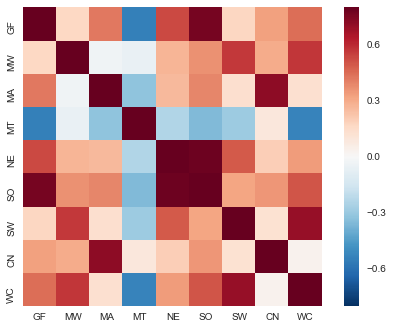

In [4]:
import pandas as pd
from linearmodels.system import SUR
mod = SUR(mod_data)
res = mod.fit(method='gls', debiased=True)
cov = res.sigma
std = np.sqrt(np.diag(res.sigma)[:,None])
regions =  [k for k in mod_data.keys()]
corr = pd.DataFrame(cov / (std @ std.T), columns=regions, index=regions)

import seaborn as sns
sns.heatmap(corr, vmax=.8, square=True)
corr

In [5]:
from linearmodels.iv import IV2SLS
ols_res = IV2SLS(mod_data['WC']['dependent'], mod_data['WC']['exog'], None,None).fit(debiased=True)
print(ols_res)
res.equations['WC'].params
res.equations['WC'].tstats


                            OLS Estimation Summary                            
Dep. Variable:                  lnGSP   R-squared:                      0.9940
Estimator:                        OLS   Adj. R-squared:                 0.9905
No. Observations:                  17   F-statistic:                    717.72
Date:                Sun, Jun 11 2017   P-value (F-stat)                0.0000
Time:                        22:20:27   Distribution:                  F(6,10)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      3.5902     4.5168     0.7949     0.4451     -6.4739      13.654
lnPC           0.2949     0.1619     1.8208     0.09

Intercept    0.003052
lnPC         0.009774
lnHWY        0.006736
lnWATER     -0.009880
lnUTIL       0.000987
lnEMP        0.034579
UNEMP       -0.008631
Name: tstat, dtype: float64

In [6]:
from linearmodels.panel import PooledOLS
pooled_mod = PooledOLS(agg_data.lnGSP, agg_data[['Intercept','lnPC','lnHWY','lnWATER','lnUTIL','lnEMP','UNEMP']])
print(pooled_mod.fit())

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lnGSP   R-squared:                        0.9961
Estimator:                  PooledOLS   R-squared (Between):              0.9986
No. Observations:                 153   R-squared (Within):               0.9517
Date:                Sun, Jun 11 2017   R-squared (Overall):              0.9961
Time:                        22:20:27   Log-likelihood                    276.72
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6269.7
Entities:                           9   P-value                           0.0000
Avg Obs:                       17.000   Distribution:                   F(6,146)
Min Obs:                       17.000                                           
Max Obs:                       17.000   F-statistic (robust):             6269.7
                            

## Estimation Options

### Restricted Residual Covariance

### Iterative GLS

### Alternative Covariance Estimators

## Pre-specified Residual Covariance Estimators

## Multivariate OLS

## Cross-Equation Restrictions